## Setup Data
- Link dataset: https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species
- Read the README.md file that contains all the information about the project. 

#### Import the libraries used

In [1]:
# General use
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier


# SVM-related libraries
from utils import SVM_hyperparameter_tuning
from utils import PCA_KNN


# KNN-related libraries
import math

from itertools import product
from sklearn.neighbors import KNeighborsClassifier
from utils import KNN_hyperparameter_tuning


# PCA-related libraries
import random

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA


# VGG extractor feature
import torch
import argparse

import torchvision.models as models

from torchvision import transforms
from torchvision.models import VGG16_Weights


## Data organization

File *"butterflies and moths.csv"* contains 4 columns:
- **class id**: numerical class of the butterfly,
- **filepaths**: path to the individual image,
- **labels**: name of the category,
- **data set**: indicates whether the i-th butterfly is for train, valid or test.

Here I load the dataset and split the data into train, valid and test sets.

In [2]:
#~ [Load dataset]
file_path = 'butterflies and moths.csv'
df = pd.read_csv(file_path)
print('Entire dataset: \n', df)

#~ [Data division into train, valid and test sets]
# For each df_* there are the: 
# - class id
# - filepaths
# - labels
# - data set
df_train = df[df['data set'] == 'train']
df_valid = df[df['data set'] == 'valid']
df_test = df[df['data set'] == 'test']


limit = 25
#~ [Different types of butterflies and moths are collected]
b_m_types = df_train['labels'].unique()
b_m_types = b_m_types[0:limit]
print('\n\nLabels: ', b_m_types)

#~ [The different id classes of butterflies and moths are collected]
b_m_class = df_train['class id'].unique()
b_m_class = b_m_class[0:limit]
print('\n\nClass id: ', b_m_class)

#~ [Consider only species indicated by the limit]
df_train = df_train[df_train["labels"].isin(b_m_types[0:limit])]
df_test = df_test[df_test["labels"].isin(b_m_types[0:limit])]
df_valid = df_valid[df_valid["labels"].isin(b_m_types[0:limit])]

# Join all dataframe
df_new = pd.concat([df_train, df_test, df_valid])

Entire dataset: 
        class id                    filepaths           labels data set
0             0         train/ADONIS/001.jpg           ADONIS    train
1             0         train/ADONIS/002.jpg           ADONIS    train
2             0         train/ADONIS/003.jpg           ADONIS    train
3             0         train/ADONIS/004.jpg           ADONIS    train
4             0         train/ADONIS/005.jpg           ADONIS    train
...         ...                          ...              ...      ...
13589        99  valid/ZEBRA LONG WING/1.jpg  ZEBRA LONG WING    valid
13590        99  valid/ZEBRA LONG WING/2.jpg  ZEBRA LONG WING    valid
13591        99  valid/ZEBRA LONG WING/3.jpg  ZEBRA LONG WING    valid
13592        99  valid/ZEBRA LONG WING/4.jpg  ZEBRA LONG WING    valid
13593        99  valid/ZEBRA LONG WING/5.jpg  ZEBRA LONG WING    valid

[13594 rows x 4 columns]


Labels:  ['ADONIS' 'AFRICAN GIANT SWALLOWTAIL' 'AMERICAN SNOOT' 'AN 88' 'APPOLLO'
 'ARCIGERA FLOWER MO

#### Analysis of the data at hand

- Figure 1: shows the number of butterflies in the dataset divided by category

- Figure 2: shows the amount of butterflies for train, test and valid sets

labels
BROWN ARGUS                  169
BROOKES BIRDWING             165
CHALK HILL BLUE              149
ATALA                        143
BROWN SIPROETA               140
ARCIGERA FLOWER MOTH         140
BANDED ORANGE HELICONIAN     139
BANDED TIGER MOTH            136
CHECQUERED SKIPPER           136
BIRD CHERRY ERMINE MOTH      133
CINNABAR MOTH                131
ATLAS MOTH                   129
APPOLLO                      128
CABBAGE WHITE                127
ADONIS                       126
BLUE SPOTTED CROW            123
CHESTNUT                     122
BLACK HAIRSTREAK             121
AN 88                        121
BANDED PEACOCK               118
CAIRNS BIRDWING              117
BECKERS WHITE                116
AFRICAN GIANT SWALLOWTAIL    107
BLUE MORPHO                  107
AMERICAN SNOOT               105
Name: count, dtype: int64


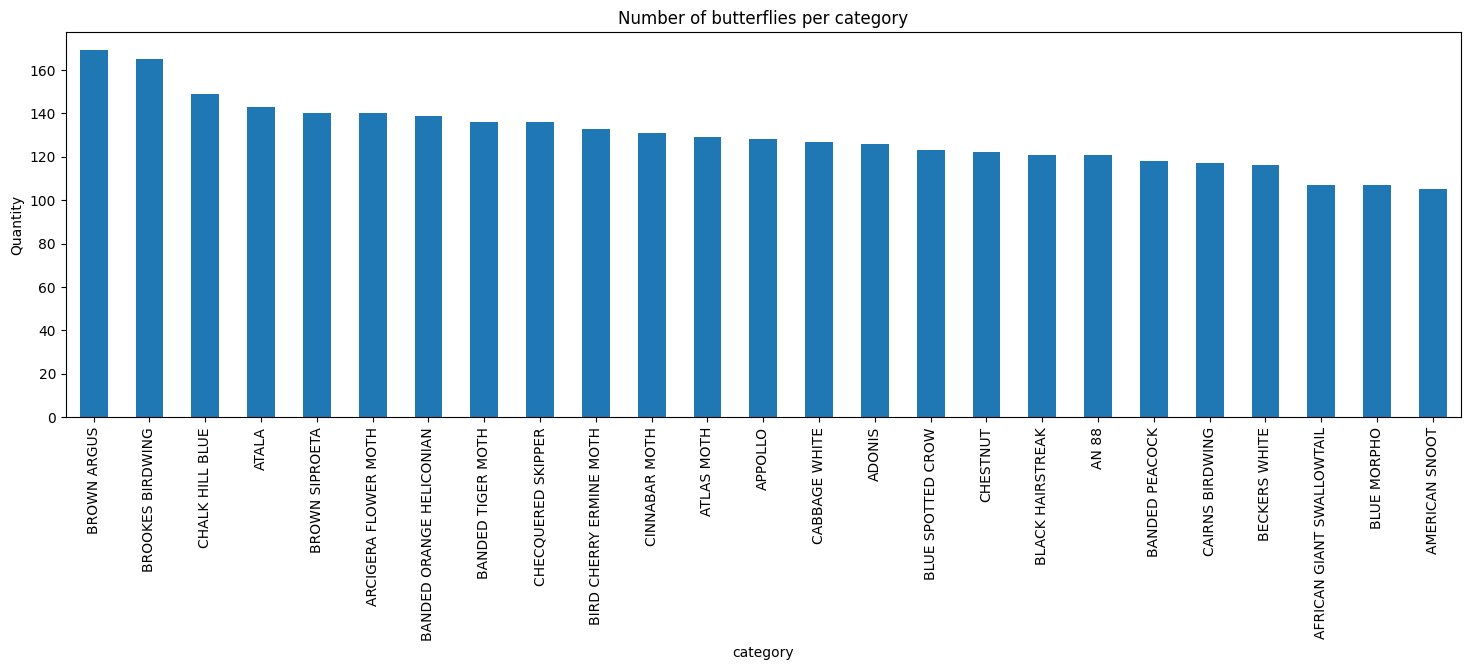

data set
train    3248
test      125
valid     125
Name: count, dtype: int64


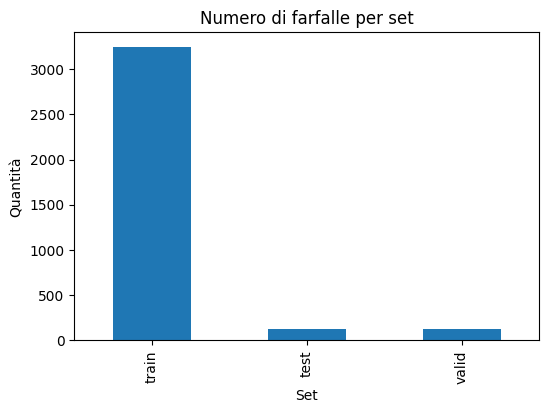

In [3]:
#~ [Calculate the number of butterflies for each category]
counts = df_train['labels'].value_counts()
print(counts)

#~ [Plot the bar graph]
plt.figure(figsize=(18,5))
counts.plot(kind='bar')
plt.title('Number of butterflies per category')
plt.xlabel('category')
plt.ylabel('Quantity')
plt.show()


#~ [Calculate the number of butterflies for each set (train, valid, test)]
counts = df_train['data set'].value_counts()
counts = pd.concat([counts, df_test['data set'].value_counts()])
counts = pd.concat([counts, df_valid['data set'].value_counts()])
print(counts)

#~ [Plot the bar graph]
plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.title('Numero di farfalle per set')
plt.xlabel('Set')
plt.ylabel('Quantità')
plt.show()

#### Data preprocessing

- Our _labels_ correspond to butterfly species (labels column)
- Our _data_ match the butterfly images
  - Images are handled in both color and black/white 
  - Images are resized to 50x50

In [4]:
#~ [A dictionary is created for species]
# b_m_types -> species name 
# b_m_class -> species class_id
species_dict = {}
for idx, i in enumerate(b_m_types[0:limit]): 
    species_dict[i] = idx

prime_dieci_chiavi = list(species_dict.keys())[:limit]                               # Get the first limit keys 
list_species = {chiave: species_dict[chiave] for chiave in prime_dieci_chiavi}       # Create new dictionary with matching keys and values

#~ [Dictionary of Images]
# Color images
img_dict_x = {
    'train': [],
    'test': [],
    'valid': []
}
img_dict_y = {
    'train': [],
    'test': [],
    'valid': []
}

# B/W images
img_dict_bn_x = {
    'train': [],
    'test': [],
    'valid': []
}
img_dict_bn_y = {
    'train': [],
    'test': [],
    'valid': []
}

# Images with HSV
img_hsv_hist_x = {
    'train': [],
    'test': [],
    'valid': []
}
img_hsv_hist_y = {
    'train': [],
    'test': [],
    'valid': []
}


images = []                             # List of colored images
images_grey = []                        # List of black/white images
images_hsv_histo = []                   # List of HSV histograms relating to images


for i, row in df_new.iterrows():
    filepath = row['filepaths']
    class_id = row['class id']
    index = row['data set']

    img = Image.open(filepath)          # Load the image from the path
    img = img.resize((50,50))           # Resize the image

    # Black/White
    img_grey = img.convert("L")                                 # Take image and convert it to grayscale
    img_dict_bn_x[index].append(np.array(img_grey).flatten())   # Take converted image and transform it into an np-array, with flatten for it to be one-dimensional
    img_dict_bn_y[index].append(class_id)                       # Take the class and add it to the index
    images_grey.append(np.array(img_grey).flatten())            # Add to the images_grey vector the img_grey    
    
    # Colored
    img_array = np.array(img)                                   # The colored image is converted to a numpy array
    img_dict_x[index].append(img_array) 
    img_dict_y[index].append(class_id)
    images.append(img_array)                                   

    # HSV histograms
    img = cv2.imread(filepath)                                 # Read images with cv2 to later analyze HSV histograms with cv2
    img = cv2.resize(img, (50,50))                             # Resize the images
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)             # Converts the image to HSV color space
    h, s, v = cv2.split(hsv_img)                               # Split the image into the separate channels
    
    hist_h = cv2.calcHist([h], [0], None, [256], [0, 256]).flatten()     # Calculate the histogram for each channel
    hist_s = cv2.calcHist([s], [0], None, [256], [0, 256]).flatten()
    hist_v = cv2.calcHist([v], [0], None, [256], [0, 256]).flatten()
    
    histo = np.concatenate((hist_h, hist_s, hist_v))           # Concatenates histograms into a single feature vector
    img_hsv_hist_x[index].append(histo)
    img_hsv_hist_y[index].append(class_id)
    images_hsv_histo.append(histo)      
    
    
#~ [Create numpy lists for the obtained lists]
images_np = np.array(images)
images_gray_np = np.array(images_grey)
images_hsv_histo_np = np.array(images_hsv_histo)

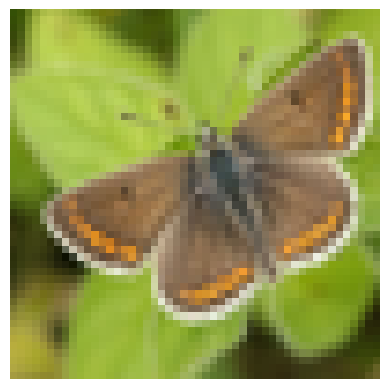

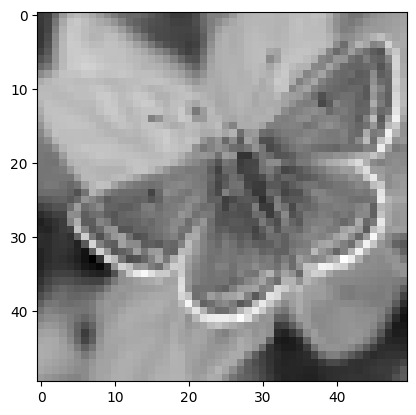

In [5]:
# This section show a random image
idx = random.randint(0, len(images)-1)    
for img in images[idx:idx+1]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

for img in images_grey[idx:idx+1]:
    img = img.reshape(50,50)
    plt.imshow(img, cmap='gray')
    plt.show()

#### Creation of train and test sets related to black/white images

- In img_dict_bn are the images converted to black/white

- Each category is already divided with the indexes 'train', 'test', 'valid'

In [6]:
print('Shape of the images_gray_np array: ',images_gray_np.shape)

x_train_bn = img_dict_bn_x['train']                 # Partition the data into the train and test set
x_test_bn = img_dict_bn_x['test']
y_train_bn = img_dict_bn_y['train']
y_test_bn = img_dict_bn_y['test']


train_data_bn = np.array(x_train_bn)                # Convert the data in np-array
test_data_bn = np.array(x_test_bn)
train_labels_bn = np.array(y_train_bn)
test_labels_bn = np.array(y_test_bn)

Shape of the images_gray_np array:  (3498, 2500)


#### Creation of train and test sets related to colered images

- In img_dict are the colored images

- Each category is already divided with the indexes 'train', 'test', 'valid'

In [7]:
print('Shape of the images_np array: ',images_np.shape)

train_data = img_dict_x['train']                    # Partition the data into the train and test set
test_data = img_dict_x['test']
x_train_colored = []
x_test_colored = []

for element in train_data:
    x_train_colored.append(element.reshape(-1))
    
for element in test_data:                 
    x_test_colored.append(element.reshape(-1))
    
y_train_colored = img_dict_y['train']
y_test_colored = img_dict_y['test']

train_data_colored = np.array(x_train_colored)     # Convert the data in np-array
test_data_colored = np.array(x_test_colored)
train_labels_colored = np.array(y_train_colored)
test_labels_colored = np.array(y_test_colored)

Shape of the images_np array:  (3498, 50, 50, 3)


#### Creation of train and test sets related to HSV

- In img_hsv_hist are the colored images

- Each category is already divided with the indexes 'train', 'test', 'valid'

In [8]:
print('Shape of the images_gray_np array: ',images_hsv_histo_np.shape)

x_train_hsv = img_hsv_hist_x['train']                 # Partition the data into the train and test set
x_test_hsv = img_hsv_hist_x['test']
y_train_hsv = img_hsv_hist_y['train']
y_test_hsv = img_hsv_hist_y['test']

train_data_hsv = np.array(x_train_hsv)                # Convert the data in np-array
test_data_hsv = np.array(x_test_hsv)
train_labels_hsv = np.array(y_train_hsv)
test_labels_hsv = np.array(y_test_hsv)

Shape of the images_gray_np array:  (3498, 768)


## Models of SVM and KNN (without using PCA) for images in black/white

#### SVM

In [9]:
kernels = ["linear", "poly", "rbf", "sigmoid"]                 # Types of kernel
gammas = ["scale", "auto"]                                     # Types of gamma

results = []                                                   # Array that memorize the results

for kn in kernels:                                             # for each kernel
    for gm in gammas:                                          # for each gamma
        # Create a classifier with OneVsRest approach
        psuedo_classifier = OneVsRestClassifier(SVC(kernel=kn, degree=1, C=1, gamma=gm, probability=True)).fit(train_data_bn, train_labels_bn)
        
        predizione = psuedo_classifier.predict(test_data_bn)   # Prediction on test data using the trained model

        accuracy = round(accuracy_score(test_labels_bn, predizione), 4)                                         # Make the accuracy study
        precision = round(precision_score(test_labels_bn, predizione, average='macro', zero_division=1), 4)     # Make the precision study
        recall = round(recall_score(test_labels_bn, predizione, average='macro', zero_division=1), 4)                            # Make the recall study
        f1 = f1_score(test_labels_bn, predizione, average='macro', zero_division=1)                                              # Make the f1 study

        # Stores SVM model performance results
        results.append({'Kernel' : kn, 'Gamma' : gm, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})

svm_df = pd.DataFrame(results)                                         # Create a dataframe with results
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)       # Reorder by accuracy the results

print(svm_df)                                                          # Show the svm results


best_row_index = svm_df['Accuracy'].idxmax()                           # Memorize the Kernel with Better Range
best_kernel = svm_df.loc[best_row_index, 'Kernel']                    
best_gamma = svm_df.loc[best_row_index, 'Gamma']

print("\nBest kernel and gamma: ", best_kernel, best_gamma)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
4      rbf  scale     0.536     0.4905   0.536  0.496092
2     poly  scale     0.336     0.2951   0.336  0.298898
0   linear  scale     0.312     0.3500   0.312  0.305395
1   linear   auto     0.312     0.3500   0.312  0.305395
3     poly   auto     0.312     0.3500   0.312  0.305395
5      rbf   auto     0.040     0.9616   0.040  0.003077
7  sigmoid   auto     0.040     0.9616   0.040  0.003077
6  sigmoid  scale     0.032     0.7614   0.032  0.002735

Best kernel and gamma:  rbf scale


#### Confusion Matrix for SVM

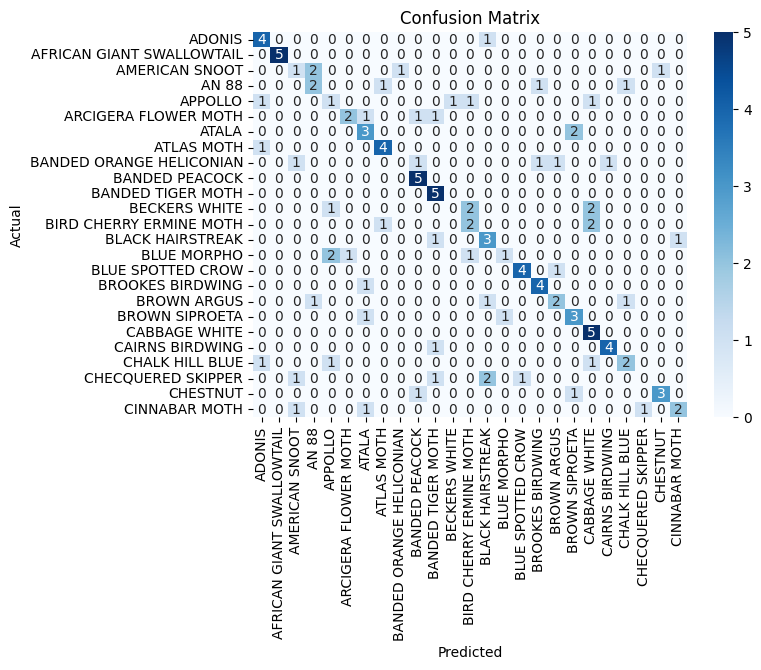

Fully supervised results: Accuracy 0.536, Precision 0.4905, Recall 0.536, F1-score 0.4960924630924631


In [10]:
# Redo the new SVM but using the best kernel and gamma
psuedo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(train_data_bn, train_labels_bn)
predictions = psuedo_classifier.predict(test_data_bn)

cm = confusion_matrix(test_labels_bn, predictions)                # Calculate the confusion matrix

plt.figure(figsize=(7,5))                                        # Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Determine the new estimation parameter 
accuracy = round(accuracy_score(test_labels_bn, predictions), 4)
precision = round(precision_score(test_labels_bn, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_bn, predictions, average='macro'), 4)
f1 = f1_score(test_labels_bn, predictions, average='macro')
print(f'Fully supervised results: Accuracy {accuracy}, Precision {precision}, Recall {recall}, F1-score {f1}')

final_results = []
final_results.append({'Pipeline': 'BW-SVM', 'Kernel' : best_kernel, 'Gamma' : best_gamma, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})

#### KNN

In [11]:
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(train_data_bn.shape[0]))]       # Use the odd values and the root of the shape
weights = ['uniform', 'distance']                                              # The wights and metrics used
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']

results = []                                                                   # The results array

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)             # Create the K-NN classifier with the current hyperparameters

    knn.fit(train_data_bn, train_labels_bn)                                    # Fit the model to the training data

    predictions = knn.predict(test_data_bn)                                     # Make predictions on the test data


    # Calulate accuracy, precision, recall and f1 values
    accuracy = round(accuracy_score(test_labels_bn, predictions), 4)
    precision = round(precision_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
    f1 = f1_score(test_labels_bn, predictions, average='macro', zero_division=1)

    results.append({'n_neighbors' : n, 'weights' : w, 'metric' : m, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})
    

knn_df = pd.DataFrame(results)                                                 # Create a dataframe with results
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)

print(knn_df)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
6             3  distance  manhattan     0.360     0.4578   0.360  0.346389
39            9  distance  minkowski     0.352     0.6552   0.352  0.339577
35            9  distance  euclidean     0.352     0.6552   0.352  0.339577
46           11  distance  manhattan     0.352     0.5250   0.352  0.327643
41           11   uniform  manhattan     0.344     0.5771   0.344  0.337332
7             3  distance     cosine     0.344     0.5452   0.344  0.355166
29            7  distance  minkowski     0.336     0.5995   0.336  0.325192
25            7  distance  euclidean     0.336     0.5995   0.336  0.325192
49           11  distance  minkowski     0.328     0.6567   0.328  0.308641
16            5  distance  manhattan     0.328     0.4386   0.328  0.310044
45           11  distance  euclidean     0.328     0.6567   0.328  0.308641
31            9   uniform  manhattan     0.328     0.5068   0.328  0.310866
11          

In [12]:
best_row_index = knn_df['Accuracy'].idxmax()                           # Look for the row in the DataFrame that has the highest accuracy

best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']           # Search the best neighbors, weights and metric
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']

print("\nBest n_neighbors, weights and metric:",best_n_neighbors, best_weights, best_metric)


Best n_neighbors, weights and metric: 3 distance manhattan


#### Confusion Matrix for KNN

Accuracy: 0.36


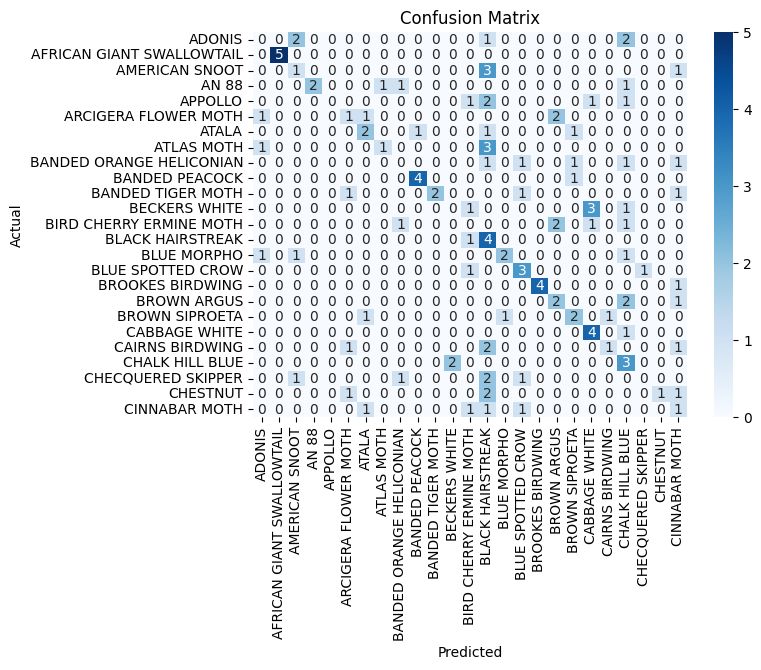

In [13]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric) # With the best parameters create a new model
knn.fit(train_data_bn, train_labels_bn)
y_pred = knn.predict(test_data_bn)

accuracy = accuracy_score(test_labels_bn, y_pred)                                                  # Calculate the accuracy
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(test_labels_bn, y_pred)                                                      # Determinate the confusion matrix

plt.figure(figsize=(7,5))                                                                          # Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Store the performance results of the KNN model 
final_results.append({'Pipeline': 'BW-KNN', 'n_neighbors' : best_n_neighbors, 'weights' : best_weights, 'metric' : best_metric, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})


## Models of SVM and KNN (using PCA) for images in black/white

#### PCA Variance threshold

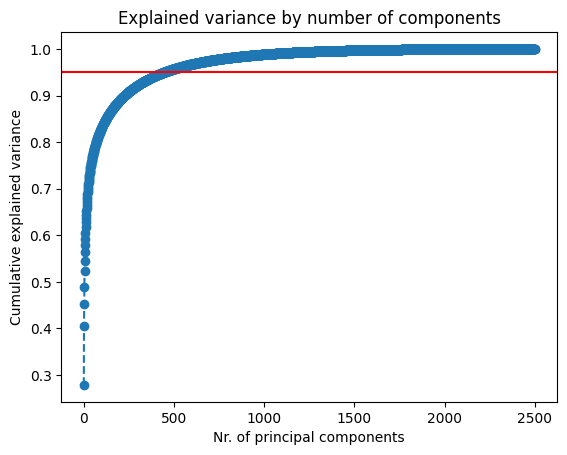

In [14]:
scaler = MinMaxScaler()                                     # Scale (normalize) the data
scaled_train_data = scaler.fit_transform(train_data_bn)     # Tranform the data in a np_array

RAND_STATE = 0                                              # Apply PCA without specifying the number of components to keep
pca = PCA(random_state = RAND_STATE)
pca.fit(scaled_train_data)

# Plot the variance ratio in a cumulative fashion, to visualize the cumulative variance plot
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle='--')
plt.axhline(y=0.95, color = 'r', linestyle = '-')
plt.title('Explained variance by number of components')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Nr. of principal components')
plt.show()

In [15]:
n_comp = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]     # Visualize the number of the component, when i go over the 95%
print('The numer of component is ', n_comp)

The numer of component is  446


Perform PCA on train data and test data:

We use the required component numbers to explain that more than 95% of the variance is used to create a new PCA object and perform final reduced dimensionalities on the data

In [16]:
pca = PCA(n_components=n_comp, random_state=RAND_STATE)      # Apply the pca
pca_train_data = pca.fit_transform(scaled_train_data)

scaled_test_data = scaler.fit_transform(test_data_bn)
pca_test_data = pca.transform(scaled_test_data)

#### SVM (using PCA) Black and white

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
4      rbf  scale     0.512     0.4835   0.512  0.480486
5      rbf   auto     0.440     0.4247   0.440  0.401628
0   linear  scale     0.352     0.4230   0.352  0.334242
1   linear   auto     0.352     0.4230   0.352  0.334242
2     poly  scale     0.312     0.2777   0.312  0.259959
7  sigmoid   auto     0.312     0.3802   0.312  0.289288
3     poly   auto     0.296     0.2719   0.296  0.246126
6  sigmoid  scale     0.176     0.2028   0.176  0.171294

Best kernel and gamma:  rbf scale


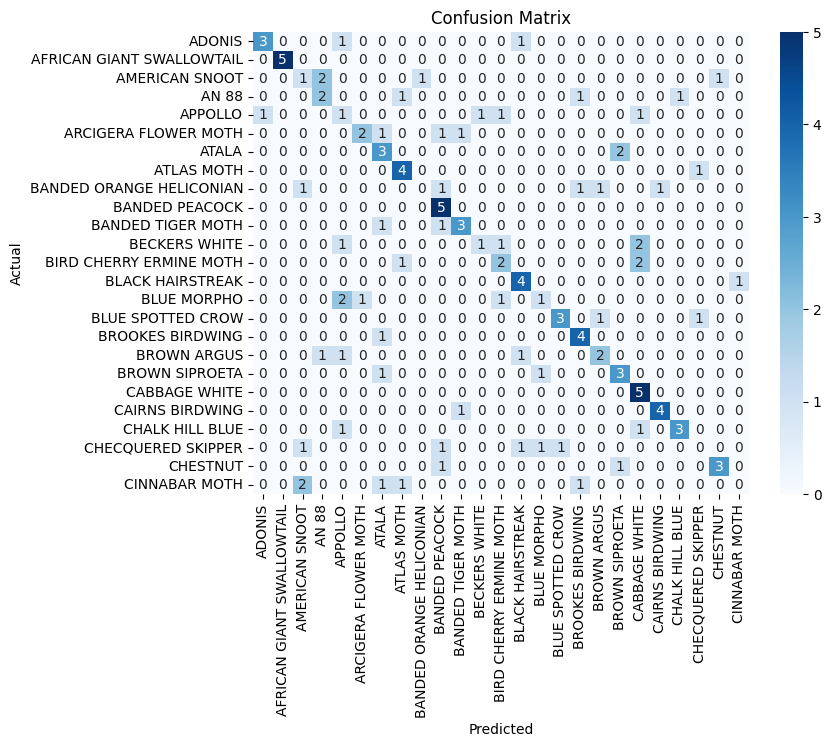

In [17]:
# Repeat svm again but with the data obtained from the pca
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
results = []

for kernel in kernels:
    for gamma in gammas:
        pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(pca_train_data, train_labels_bn)
        
        predictions = pseudo_classifier.predict(pca_test_data)

        acc = round(accuracy_score(test_labels_bn, predictions), 4)
        precision = round(precision_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
        recall = round(recall_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
        f1 = f1_score(test_labels_bn, predictions, average='macro', zero_division=1)

        results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)  
print(svm_df)

best_row_index = svm_df['Accuracy'].idxmax()
best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']
print("\nBest kernel and gamma: ", best_kernel, best_gamma)

pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(pca_train_data, train_labels_bn)
predictions = pseudo_classifier.predict(pca_test_data)

cm = confusion_matrix(test_labels_bn, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

acc = round(accuracy_score(test_labels_bn, predictions), 4)
precision = round(precision_score(test_labels_bn, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_bn, predictions, average='macro'), 4)
f1 = f1_score(test_labels_bn, predictions, average='macro')

result={'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result['Pipeline'] = 'BW-PCA-SVM'       
final_results.append(result)

#### K-NN (using PCA) Black/White

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
7             3  distance     cosine     0.408     0.4500   0.408  0.384814
8             3  distance  chebyshev     0.400     0.4181   0.400  0.397957
18            5  distance  chebyshev     0.384     0.3739   0.384  0.372136
27            7  distance     cosine     0.376     0.4124   0.376  0.341674
2             3   uniform     cosine     0.368     0.4499   0.368  0.353815
47           11  distance     cosine     0.368     0.4352   0.368  0.332365
37            9  distance     cosine     0.368     0.4421   0.368  0.336150
28            7  distance  chebyshev     0.360     0.3807   0.360  0.350660
17            5  distance     cosine     0.352     0.4470   0.352  0.316856
29            7  distance  minkowski     0.344     0.5437   0.344  0.335935
25            7  distance  euclidean     0.344     0.5437   0.344  0.335935
19            5  distance  minkowski     0.336     0.5583   0.336  0.321864
38          

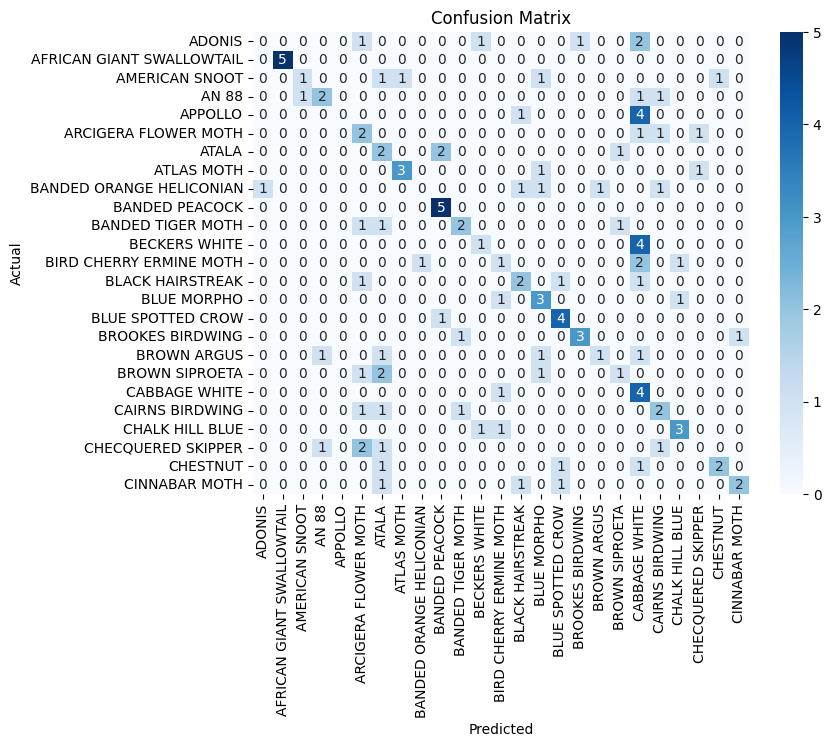

In [18]:
# Repeat knn again but with the data obtained from the pca
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(pca_train_data.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = []

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    knn.fit(pca_train_data, train_labels_bn)
    
    predictions = knn.predict(pca_test_data)
    accuracy = accuracy_score(test_labels_bn, predictions)
    
    acc = round(accuracy_score(test_labels_bn, predictions), 4)
    precision = round(precision_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)    
    f1 = f1_score(test_labels_bn, predictions, average='macro', zero_division=1)

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(knn_df)  

best_row_index = knn_df['Accuracy'].idxmax()
best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']
print(best_n_neighbors, best_weights, best_metric)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(pca_train_data, train_labels_bn)
y_pred = knn.predict(pca_test_data)

accuracy = accuracy_score(test_labels_bn, y_pred)
print("Accuracy:", accuracy)
precision = round(precision_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
recall = round(recall_score(test_labels_bn, predictions, average='macro', zero_division=1), 4)
f1 = f1_score(test_labels_bn, predictions, average='macro', zero_division=1)

cm = confusion_matrix(test_labels_bn, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
result ={'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result['Pipeline'] = 'BW-PCA-KNN'
final_results.append(result)

In [19]:
# Create a table with the best performance of the models with their parameters
res_df = pd.DataFrame(final_results)                                                         
res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)

res_df

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,0.360,0.6572,0.256,0.226042,3.0,distance,manhattan
3,BW-PCA-KNN,NaN,NaN,0.408,0.6333,0.280,0.249847,3.0,distance,cosine
0,BW-SVM,rbf,scale,0.536,0.4905,0.536,0.496092,NaN,NaN,NaN
2,BW-PCA-SVM,rbf,scale,0.512,0.4835,0.512,0.480486,NaN,NaN,NaN


## Models of SVM and KNN (without using PCA) for colored images

In [20]:
# Print some information about our images
print(f'Number of images: {len(images)}')
images_np = np.array(images)

print('Shape of images: ', images_np.shape)                                  

images_np_res = images_np.reshape((len(images)), -1)
print('Reshape of images: ', images_np_res.shape)

Number of images: 3498
Shape of images:  (3498, 50, 50, 3)
Reshape of images:  (3498, 7500)


#### SVM (without PCA)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
4      rbf  scale     0.680     0.7166   0.680  0.670687
2     poly  scale     0.504     0.5183   0.504  0.470780
0   linear  scale     0.496     0.5420   0.496  0.487461
1   linear   auto     0.496     0.5420   0.496  0.487461
3     poly   auto     0.496     0.5420   0.496  0.487461
5      rbf   auto     0.040     0.9616   0.040  0.003077
6  sigmoid  scale     0.040     0.8048   0.040  0.007513
7  sigmoid   auto     0.040     0.9616   0.040  0.003077

Best kernel and gamma:  rbf scale


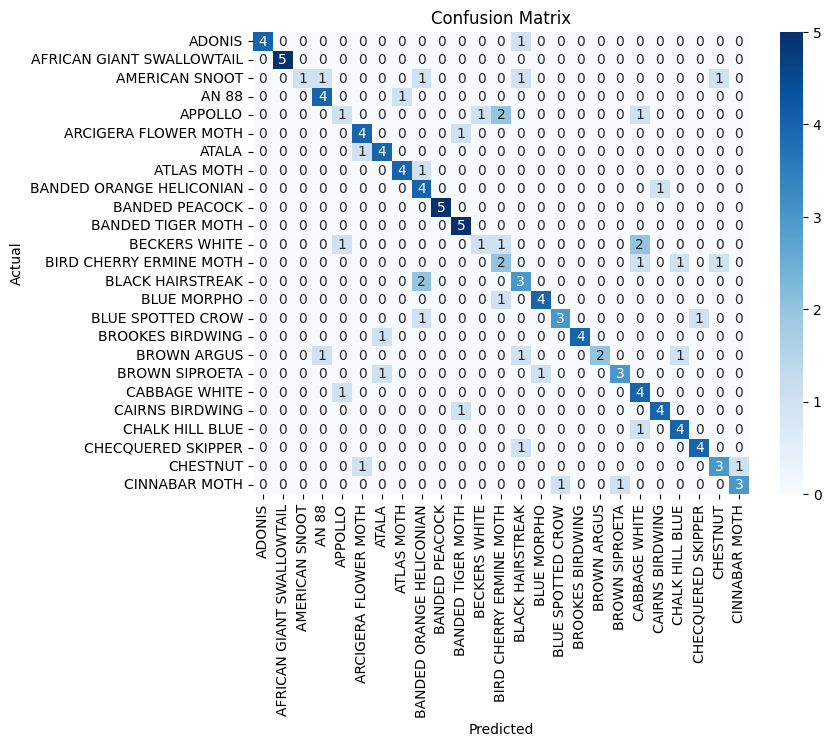

In [21]:
# Repeat svm again but with the data obtained from the pca
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
results = []

for kernel in kernels:
    for gamma in gammas:
        pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(train_data_colored, train_labels_colored)
        
        predictions = pseudo_classifier.predict(test_data_colored)

        acc = round(accuracy_score(test_labels_colored, predictions), 4)
        precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
        recall = round(recall_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
        f1 = f1_score(test_labels_colored, predictions, average='macro', zero_division=1)

        results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)  
print(svm_df)

best_row_index = svm_df['Accuracy'].idxmax()
best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']
print("\nBest kernel and gamma: ", best_kernel, best_gamma)

pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(train_data_colored, train_labels_colored)
predictions = pseudo_classifier.predict(test_data_colored)

cm = confusion_matrix(test_labels_colored, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

acc = round(accuracy_score(test_labels_colored, predictions), 4)
precision = round(precision_score(test_labels_colored, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_colored, predictions, average='macro'), 4)
f1 = f1_score(test_labels_colored, predictions, average='macro')

result={'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result["Pipeline"]="RGB-SVM"
final_results.append(result)

#### KNN (without PCA)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
16            5  distance  manhattan     0.488     0.6471   0.488  0.480243
26            7  distance  manhattan     0.480     0.6366   0.480  0.459961
5             3  distance  euclidean     0.480     0.6929   0.480  0.481660
9             3  distance  minkowski     0.480     0.6929   0.480  0.481660
6             3  distance  manhattan     0.472     0.6041   0.472  0.458453
25            7  distance  euclidean     0.448     0.6903   0.448  0.433433
1             3   uniform  manhattan     0.448     0.5671   0.448  0.423792
11            5   uniform  manhattan     0.448     0.6165   0.448  0.428977
29            7  distance  minkowski     0.448     0.6903   0.448  0.433433
19            5  distance  minkowski     0.440     0.6894   0.440  0.430460
36            9  distance  manhattan     0.440     0.6621   0.440  0.427060
15            5  distance  euclidean     0.440     0.6894   0.440  0.430460
0           

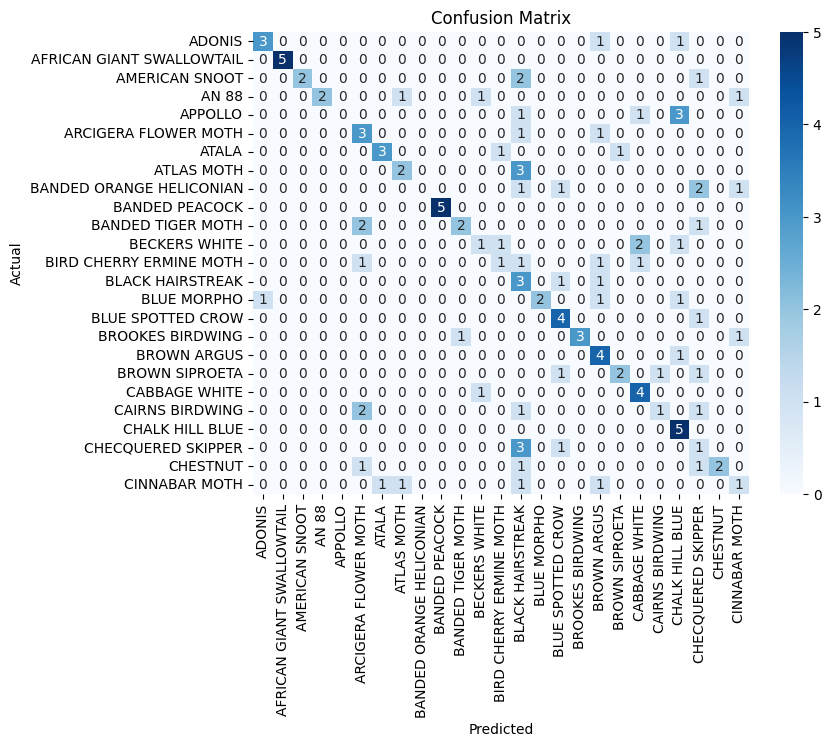

In [22]:
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(train_data_colored.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = []

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    knn.fit(train_data_colored, train_labels_colored)
    
    predictions = knn.predict(test_data_colored)
    accuracy = accuracy_score(test_labels_colored, predictions)
    
    acc = round(accuracy_score(test_labels_colored, predictions), 4)
    precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)    
    f1 = f1_score(test_labels_colored, predictions, average='macro', zero_division=1)

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(knn_df)  

best_row_index = knn_df['Accuracy'].idxmax()
best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']
print(best_n_neighbors, best_weights, best_metric)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(train_data_colored, train_labels_colored)
y_pred = knn.predict(test_data_colored)

accuracy = accuracy_score(test_labels_colored, y_pred)
print("Accuracy:", accuracy)
precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
recall = round(recall_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
f1 = f1_score(test_labels_colored, predictions, average='macro', zero_division=1)

cm = confusion_matrix(test_labels_colored, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

result={'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result["Pipeline"]="RGB-KNN"
final_results.append(result)

## Models of SVM and KNN (using PCA) for colored images

#### PCA Variance threshold

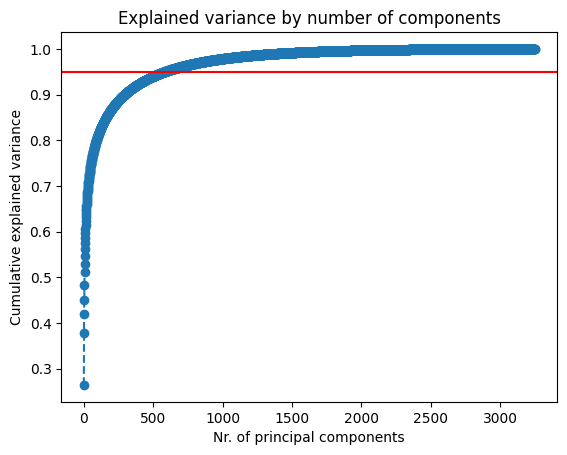

582


In [23]:
scaler = MinMaxScaler()                                                   # Normalize the data
scaled_train_data = scaler.fit_transform(train_data_colored)

pca = PCA(random_state=RAND_STATE)                                        # Apply PCA
pca.fit(scaled_train_data)

# Plot the results from the pca
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(y=0.95, color = 'r', linestyle='-')
plt.title('Explained variance by number of components')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Nr. of principal components')
plt.show()

# Determine the number of principal components needed to explain at least 95 percent of the variance in the data 
n_comp = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]         
print(n_comp)

Use the number of components needed to explain more than 80% of the variance in order to create a new PCA object and perform the final dimensionality reduction on the data

In [24]:
pca = PCA(n_components=n_comp, random_state=RAND_STATE)        # Create a pca object 
pca_train_data = pca.fit_transform(scaled_train_data)          # Normalize the data

scaled_test_data = scaler.fit_transform(test_data_colored)
pca_test_data = pca.transform(scaled_test_data)                # Apply pca to the normalize data

#### SVM (with PCA)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
4      rbf  scale     0.680     0.7145   0.680  0.665420
5      rbf   auto     0.680     0.7196   0.680  0.669501
2     poly  scale     0.520     0.5304   0.520  0.486944
3     poly   auto     0.504     0.4972   0.504  0.462247
0   linear  scale     0.464     0.4947   0.464  0.445790
1   linear   auto     0.464     0.4947   0.464  0.445790
7  sigmoid   auto     0.312     0.3127   0.312  0.292289
6  sigmoid  scale     0.272     0.3158   0.272  0.273146

Best kernel and gamma:  rbf scale


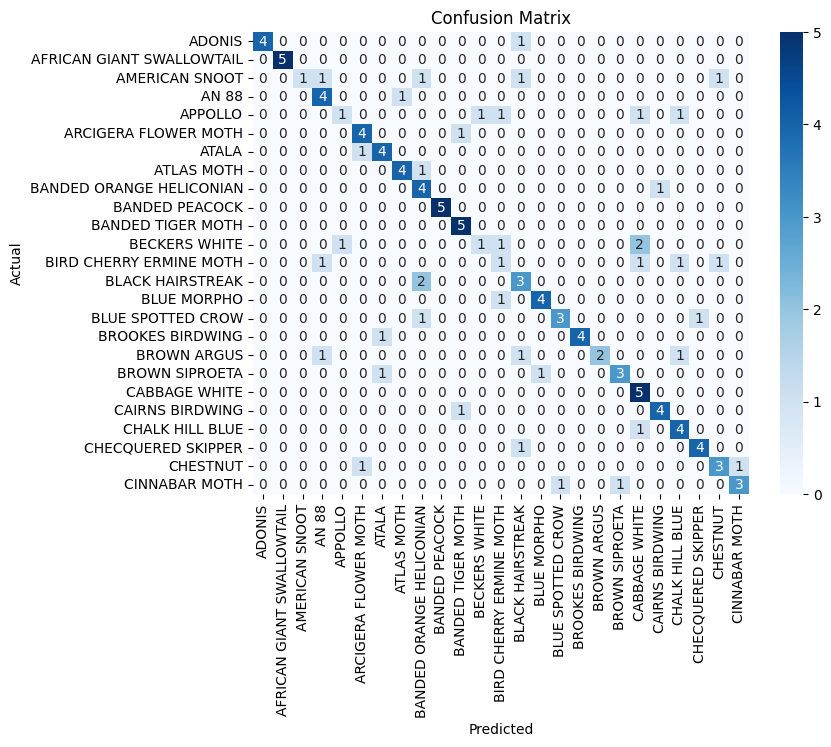

In [25]:
# Repeat svm again but with the data obtained from the pca
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
results = []

for kernel in kernels:
    for gamma in gammas:
        pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(pca_train_data, train_labels_colored)
        
        predictions = pseudo_classifier.predict(pca_test_data)

        acc = round(accuracy_score(test_labels_colored, predictions), 4)
        precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
        recall = round(recall_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
        f1 = f1_score(test_labels_colored, predictions, average='macro', zero_division=1)

        results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)  
print(svm_df)

best_row_index = svm_df['Accuracy'].idxmax()
best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']
print("\nBest kernel and gamma: ", best_kernel, best_gamma)

pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(pca_train_data, train_labels_colored)
predictions = pseudo_classifier.predict(pca_test_data)

cm = confusion_matrix(test_labels_colored, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

acc = round(accuracy_score(test_labels_colored, predictions), 4)
precision = round(precision_score(test_labels_colored, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_colored, predictions, average='macro'), 4)
f1 = f1_score(test_labels_colored, predictions, average='macro')

result={'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1}


result["Pipeline"]="RGB-PCA-SVM"
final_results.append(result)

#### KNN (with PCA)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
7             3  distance     cosine     0.504     0.5463   0.504  0.495365
5             3  distance  euclidean     0.472     0.6996   0.472  0.475204
9             3  distance  minkowski     0.472     0.6996   0.472  0.475204
37            9  distance     cosine     0.464     0.5370   0.464  0.456375
2             3   uniform     cosine     0.456     0.5302   0.456  0.451631
47           11  distance     cosine     0.456     0.5201   0.456  0.432173
18            5  distance  chebyshev     0.448     0.5058   0.448  0.436784
17            5  distance     cosine     0.440     0.5043   0.440  0.426004
15            5  distance  euclidean     0.440     0.6712   0.440  0.435344
27            7  distance     cosine     0.440     0.4672   0.440  0.417183
19            5  distance  minkowski     0.440     0.6712   0.440  0.435344
29            7  distance  minkowski     0.432     0.6970   0.432  0.424996
25          

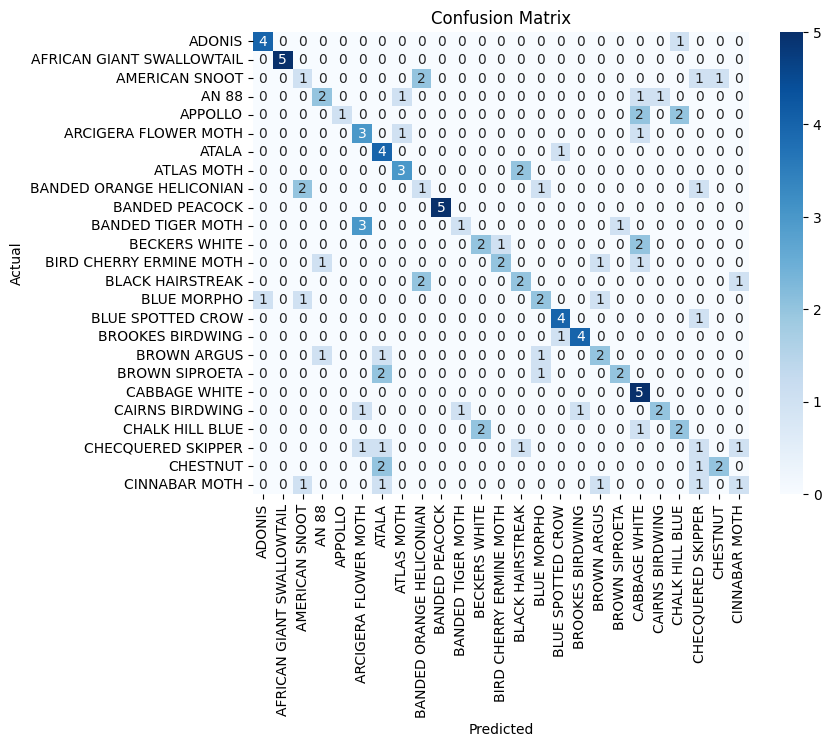

In [26]:
# Repeat knn again but with the data obtained from the pca
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(pca_train_data.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = []

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    knn.fit(pca_train_data, train_labels_colored)
    
    predictions = knn.predict(pca_test_data)
    accuracy = accuracy_score(test_labels_colored, predictions)
    
    acc = round(accuracy_score(test_labels_colored, predictions), 4)
    precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)    
    f1 = f1_score(test_labels_colored, predictions, average='macro', zero_division=1)

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(knn_df)  

best_row_index = knn_df['Accuracy'].idxmax()
best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']
print(best_n_neighbors, best_weights, best_metric)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(pca_train_data, train_labels_colored)
y_pred = knn.predict(pca_test_data)

accuracy = accuracy_score(test_labels_colored, y_pred)
print("Accuracy:", accuracy)
precision = round(precision_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
recall = round(recall_score(test_labels_colored, predictions, average='macro', zero_division=1), 4)
f1 = f1_score(test_labels_colored, predictions, average='macro', zero_division=1)

cm = confusion_matrix(test_labels_colored, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
result ={'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result["Pipeline"]="RGB-PCA-KNN"
final_results.append(result)

#### Comparing results

In [27]:
res_df = pd.DataFrame(final_results)                                                          # Create DataFrame from final results
res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)     # Sort by last character in Pipeline column descending
res_df                                                                                        # Show the sorted DataFrame

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,0.360,0.6572,0.256,0.226042,3.0,distance,manhattan
3,BW-PCA-KNN,NaN,NaN,0.408,0.6333,0.280,0.249847,3.0,distance,cosine
5,RGB-KNN,NaN,NaN,0.488,0.6366,0.312,0.275086,5.0,distance,manhattan
7,RGB-PCA-KNN,NaN,NaN,0.504,0.7027,0.320,0.282514,3.0,distance,cosine
0,BW-SVM,rbf,scale,0.536,0.4905,0.536,0.496092,NaN,NaN,NaN
2,BW-PCA-SVM,rbf,scale,0.512,0.4835,0.512,0.480486,NaN,NaN,NaN
4,RGB-SVM,rbf,scale,0.680,0.7166,0.680,0.670687,NaN,NaN,NaN
6,RGB-PCA-SVM,rbf,scale,0.680,0.7145,0.680,0.665420,NaN,NaN,NaN


## Models of SVM and KNN (without using PCA) for HSV images

#### SVM

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
4      rbf  scale     0.552     0.5302   0.552  0.526581
2     poly  scale     0.400     0.4285   0.400  0.377060
3     poly   auto     0.280     0.2825   0.280  0.267229
0   linear  scale     0.232     0.2607   0.232  0.228675
1   linear   auto     0.232     0.2607   0.232  0.228675
6  sigmoid  scale     0.128     0.3826   0.128  0.099144
5      rbf   auto     0.040     0.9616   0.040  0.003077
7  sigmoid   auto     0.040     0.9616   0.040  0.003077

Best kernel and gamma:  rbf scale


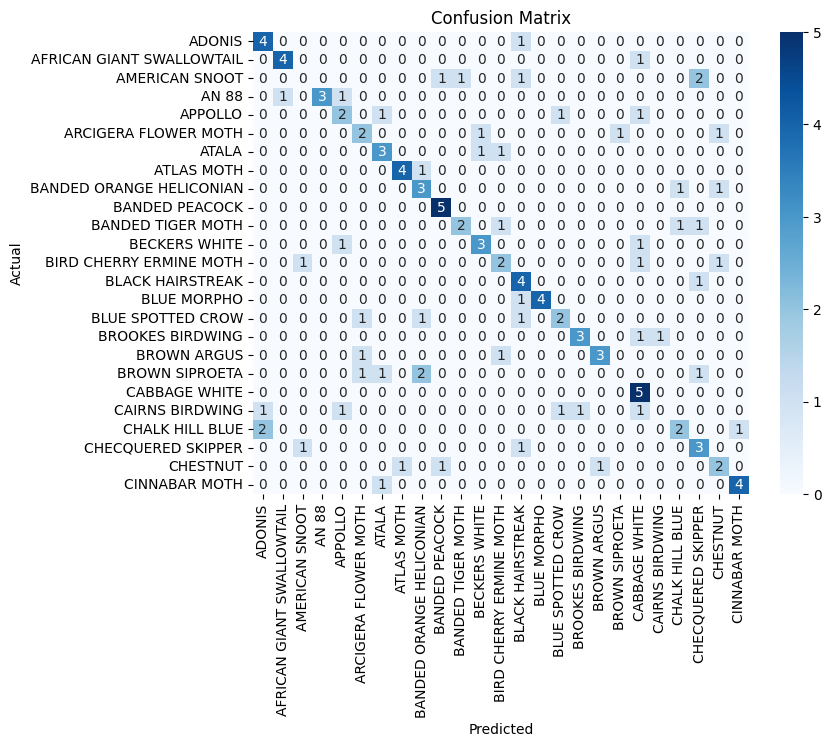

In [28]:
# SVM is applied on HSV data
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
results = []

for kernel in kernels:
    for gamma in gammas:
        pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(train_data_hsv, train_labels_hsv)
        
        predictions = pseudo_classifier.predict(test_data_hsv)

        acc = round(accuracy_score(test_labels_hsv, predictions), 4)
        precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
        recall = round(recall_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
        f1 = f1_score(test_labels_hsv, predictions, average='macro', zero_division=1)

        results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)  
print(svm_df)

best_row_index = svm_df['Accuracy'].idxmax()
best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']
print("\nBest kernel and gamma: ", best_kernel, best_gamma)

pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(train_data_hsv, train_labels_hsv)
predictions = pseudo_classifier.predict(test_data_hsv)

cm = confusion_matrix(test_labels_hsv, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

acc = round(accuracy_score(test_labels_hsv, predictions), 4)
precision = round(precision_score(test_labels_hsv, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_hsv, predictions, average='macro'), 4)
f1 = f1_score(test_labels_hsv, predictions, average='macro')

result={'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1}


result["Pipeline"]="HSV-SVM"
final_results.append(result)

#### KNN

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
41           11   uniform  manhattan     0.424     0.4893   0.424  0.421553
6             3  distance  manhattan     0.416     0.4905   0.416  0.407550
46           11  distance  manhattan     0.408     0.4959   0.408  0.409970
31            9   uniform  manhattan     0.400     0.4639   0.400  0.385846
16            5  distance  manhattan     0.400     0.4500   0.400  0.397423
1             3   uniform  manhattan     0.392     0.4952   0.392  0.387945
25            7  distance  euclidean     0.376     0.4143   0.376  0.366826
29            7  distance  minkowski     0.376     0.4143   0.376  0.366826
36            9  distance  manhattan     0.376     0.4448   0.376  0.370489
26            7  distance  manhattan     0.368     0.4098   0.368  0.360196
27            7  distance     cosine     0.368     0.4471   0.368  0.356890
35            9  distance  euclidean     0.368     0.4152   0.368  0.361428
39          

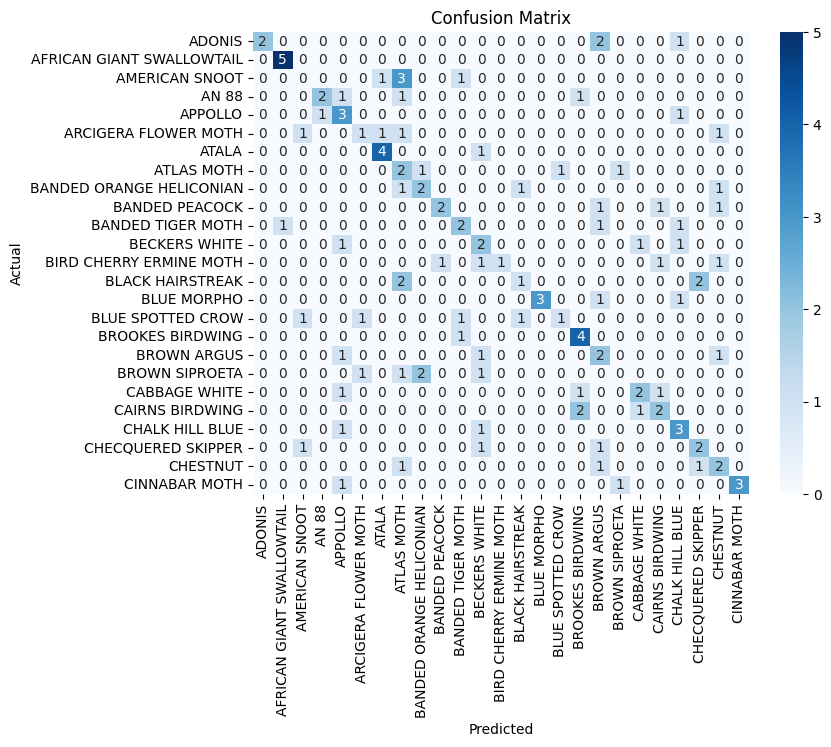

In [29]:
# KNN is applied on HSV data
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(train_data_hsv.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = []

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    knn.fit(train_data_hsv, train_labels_hsv)
    
    predictions = knn.predict(test_data_hsv)
    accuracy = accuracy_score(test_labels_hsv, predictions)
    
    acc = round(accuracy_score(test_labels_hsv, predictions), 4)
    precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)    
    f1 = f1_score(test_labels_hsv, predictions, average='macro', zero_division=1)

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(knn_df)  

best_row_index = knn_df['Accuracy'].idxmax()
best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']
print(best_n_neighbors, best_weights, best_metric)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(train_data_hsv, train_labels_hsv)
y_pred = knn.predict(test_data_hsv)

accuracy = accuracy_score(test_labels_hsv, y_pred)
print("Accuracy:", accuracy)
precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
recall = round(recall_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
f1 = f1_score(test_labels_hsv, predictions, average='macro', zero_division=1)

cm = confusion_matrix(test_labels_hsv, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
result ={'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result["Pipeline"]="HSV-KNN"
final_results.append(result)

## Models of SVM and KNN (using PCA) for HSV images

#### PCA Variance threshold

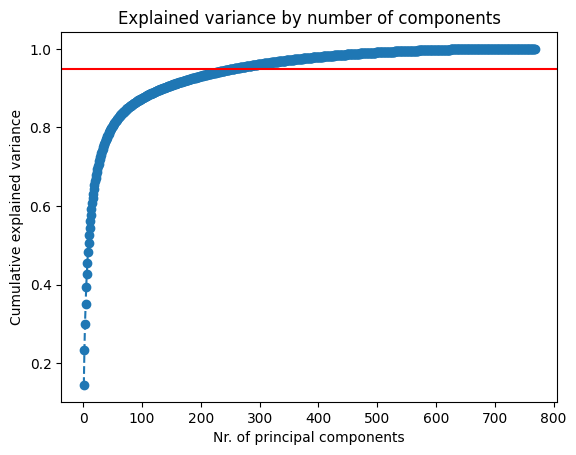

257


In [30]:
# Scale (Normalize) the data.
scaler = MinMaxScaler()                   # x-min / max-min
scaled_train_data = scaler.fit_transform(train_data_hsv)  # Data here become a np array, it's no longer a dataframe.

# Apply PCA without specifying the number of components to keep, in order to understand how many PCs are sufficient.
pca = PCA(random_state=RAND_STATE)
pca.fit(scaled_train_data)

# Plot the explained variance ratio in a cumulative fashion, in order to visualize the cumulative variance plot.
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(y=0.95, color = 'r', linestyle='-')
plt.title('Explained variance by number of components')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Nr. of principal components')
plt.show()

n_comp = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]
print(n_comp)

# Use the number of components needed to explain more than 80% of the variance in order to create a new PCA object and
# perform the final dimensionality reduction on the data.
pca = PCA(n_components=n_comp, random_state=RAND_STATE)
pca_train_data = pca.fit_transform(scaled_train_data)

scaled_test_data = scaler.fit_transform(test_data_hsv)
pca_test_data = pca.transform(scaled_test_data)

#### SVM (with PCA)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale     0.256     0.5080   0.256  0.204585
1   linear   auto     0.256     0.5080   0.256  0.204585
5      rbf   auto     0.256     0.4955   0.256  0.212848
3     poly   auto     0.240     0.4693   0.240  0.187489
7  sigmoid   auto     0.232     0.4495   0.232  0.183997
2     poly  scale     0.216     0.4767   0.216  0.165197
6  sigmoid  scale     0.168     0.3122   0.168  0.154059
4      rbf  scale     0.064     0.8448   0.064  0.056667

Best kernel and gamma:  linear scale


/home/programmazionetime/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


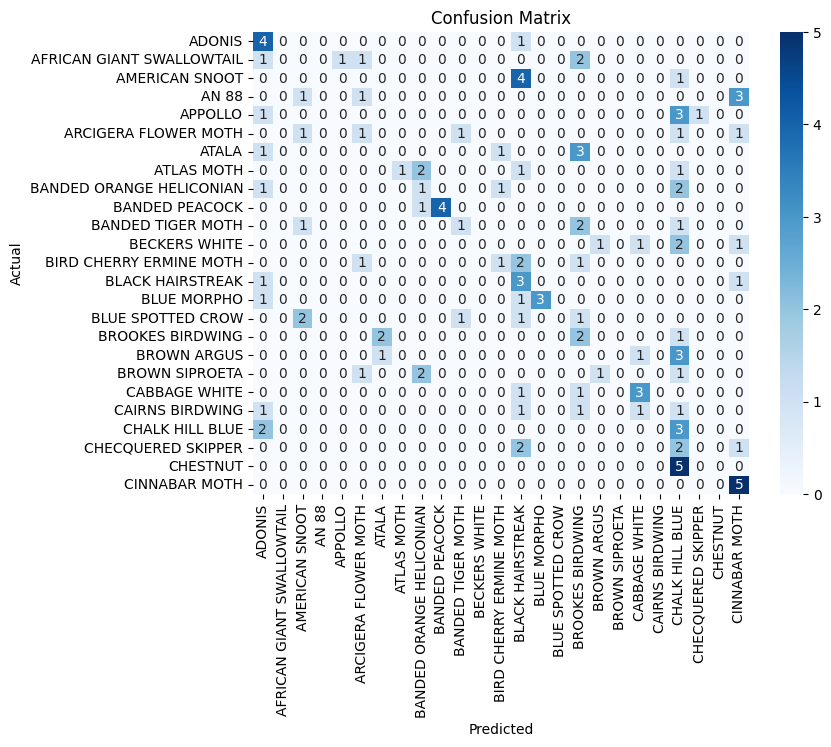

In [31]:
# SVM is applied on HSV data with PCA
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
results = []

for kernel in kernels:
    for gamma in gammas:
        pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(pca_train_data, train_labels_hsv)
        
        predictions = pseudo_classifier.predict(pca_test_data)

        acc = round(accuracy_score(test_labels_hsv, predictions), 4)
        precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
        recall = round(recall_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
        f1 = f1_score(test_labels_hsv, predictions, average='macro', zero_division=1)

        results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)  
print(svm_df)

best_row_index = svm_df['Accuracy'].idxmax()
best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']
print("\nBest kernel and gamma: ", best_kernel, best_gamma)

pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(pca_train_data, train_labels_hsv)
predictions = pseudo_classifier.predict(pca_test_data)

cm = confusion_matrix(test_labels_hsv, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

acc = round(accuracy_score(test_labels_hsv, predictions), 4)
precision = round(precision_score(test_labels_hsv, predictions, average='macro'), 4)
recall = round(recall_score(test_labels_hsv, predictions, average='macro'), 4)
f1 = f1_score(test_labels_hsv, predictions, average='macro')

result={'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1}


result["Pipeline"]="HSV-PCA-SVM"
final_results.append(result)

#### KNN (with PCA)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
56           57  distance  manhattan     0.280     0.4033   0.280  0.260410
27            7  distance     cosine     0.272     0.3455   0.272  0.265704
7             3  distance     cosine     0.272     0.3540   0.272  0.259116
42           11   uniform     cosine     0.272     0.3066   0.272  0.242612
51           57   uniform  manhattan     0.272     0.3956   0.272  0.251879
37            9  distance     cosine     0.264     0.3031   0.264  0.252877
5             3  distance  euclidean     0.264     0.2579   0.264  0.253896
9             3  distance  minkowski     0.264     0.2579   0.264  0.253896
26            7  distance  manhattan     0.264     0.3347   0.264  0.260025
32            9   uniform     cosine     0.256     0.3085   0.256  0.234681
47           11  distance     cosine     0.256     0.3293   0.256  0.250116
17            5  distance     cosine     0.248     0.3213   0.248  0.239587
2           

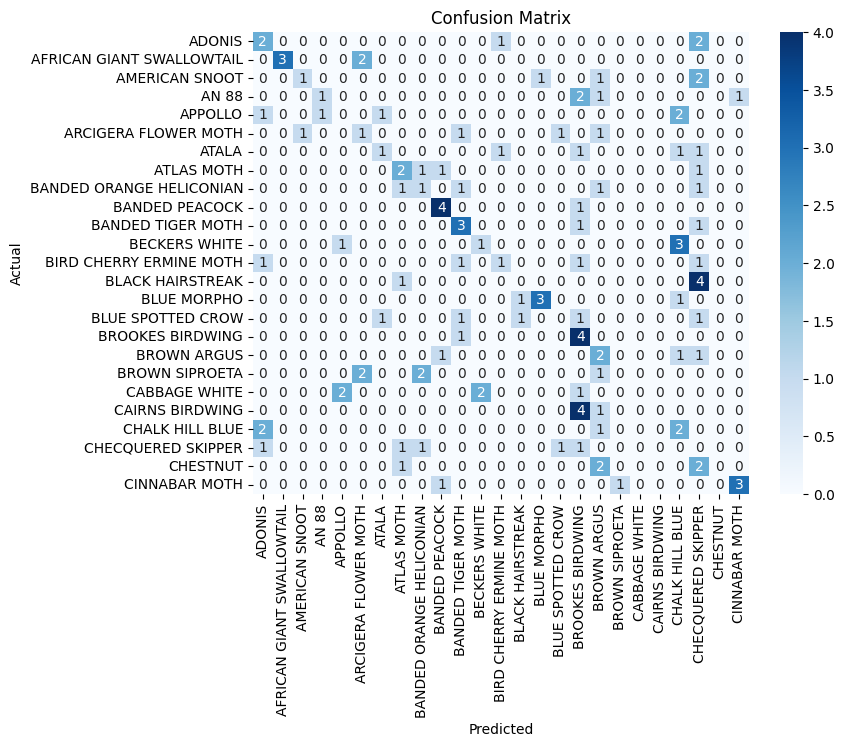

In [32]:
# KNN is applied on HSV data with PCA
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(pca_train_data.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = []

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    knn.fit(pca_train_data, train_labels_hsv)
    
    predictions = knn.predict(pca_test_data)
    accuracy = accuracy_score(test_labels_hsv, predictions)
    
    acc = round(accuracy_score(test_labels_hsv, predictions), 4)
    precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)    
    f1 = f1_score(test_labels_hsv, predictions, average='macro', zero_division=1)

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(knn_df)  

best_row_index = knn_df['Accuracy'].idxmax()
best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']
print(best_n_neighbors, best_weights, best_metric)

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(pca_train_data, train_labels_hsv)
y_pred = knn.predict(pca_test_data)

accuracy = accuracy_score(test_labels_hsv, y_pred)
print("Accuracy:", accuracy)
precision = round(precision_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
recall = round(recall_score(test_labels_hsv, predictions, average='macro', zero_division=1), 4)
f1 = f1_score(test_labels_hsv, predictions, average='macro', zero_division=1)

cm = confusion_matrix(test_labels_hsv, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
result ={'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

result["Pipeline"]="HSV-PCA-KNN"
final_results.append(result)

#### Comparing results

In [33]:
res_df = pd.DataFrame(final_results)                                                          # Create DataFrame from final results
res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)     # Sort by last character in Pipeline column descending
res_df                                                                                        # Show the sorted DataFrame

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,0.360,0.6572,0.256,0.226042,3.0,distance,manhattan
3,BW-PCA-KNN,NaN,NaN,0.408,0.6333,0.280,0.249847,3.0,distance,cosine
5,RGB-KNN,NaN,NaN,0.488,0.6366,0.312,0.275086,5.0,distance,manhattan
7,RGB-PCA-KNN,NaN,NaN,0.504,0.7027,0.320,0.282514,3.0,distance,cosine
9,HSV-KNN,NaN,NaN,0.424,0.4731,0.320,0.313528,11.0,uniform,manhattan
11,HSV-PCA-KNN,NaN,NaN,0.280,0.3036,0.168,0.135688,57.0,distance,manhattan
0,BW-SVM,rbf,scale,0.536,0.4905,0.536,0.496092,NaN,NaN,NaN
2,BW-PCA-SVM,rbf,scale,0.512,0.4835,0.512,0.480486,NaN,NaN,NaN
4,RGB-SVM,rbf,scale,0.680,0.7166,0.680,0.670687,NaN,NaN,NaN
6,RGB-PCA-SVM,rbf,scale,0.680,0.7145,0.680,0.665420,NaN,NaN,NaN


## VGG Extractor Feature

In [34]:
normalization_std = [0.229, 0.224, 0.225]
normalization_mean = [0.485, 0.456, 0.406]

loader  = transforms.Compose([transforms.ToTensor(),
                              transforms.RandomResizedCrop(224),
                              transforms.Normalize(mean=normalization_mean,
                                                   std=normalization_std)])


# Initialing compute device (use GPU if available).
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vgg_dict_x = {
    'train': [],
    'test': [],
    'valid': []
}
vgg_dict_y = {
    'train': [],
    'test': [],
    'valid': []
}

# Initialize the model.
model = models.vgg16(weights=VGG16_Weights.DEFAULT).features.to(device)
model.eval()  # Set the model to evaluation mode


for i, row in df_new.iterrows():
    filepath = row['filepaths']
    class_id = row['class id']
    index = row['data set']

    image = Image.open(filepath).convert('RGB')
    # Fake batch dimension required to fit network's input dimensions.
    image = loader(image).unsqueeze(0).to(device)

    # Extract features
    with torch.no_grad():
        features = model(image).squeeze().cpu().numpy()
        features_flattened = features.flatten()  # Flatten the features
        vgg_dict_x[index].append(features_flattened)  # Append the flattened features
        vgg_dict_y[index].append(class_id)  # Append the class_id

# Convert lists to numpy arrays
features_train = np.array(vgg_dict_x['train'])
features_test = np.array(vgg_dict_x['test'])
labels_train = np.array(vgg_dict_y['train'])
labels_test = np.array(vgg_dict_y['test'])

print(features_train.shape)
print(features_test.shape)

(3248, 25088)
(125, 25088)


#### SVM

In [35]:
kernels = ["linear", "poly", "rbf", "sigmoid"]                 # Types of kernel
gammas = ["scale", "auto"]                                     # Types of gamma

results = []                                                   # Array that memorize the results

for kn in kernels:                                             # for each kernel
    for gm in gammas:                                          # for each gamma
        # Create a classifier with OneVsRest approach
        psuedo_classifier = OneVsRestClassifier(SVC(kernel=kn, degree=1, C=1, gamma=gm, probability=True)).fit(features_train, labels_train)
        
        predizione = psuedo_classifier.predict(features_test)   # Prediction on test data using the trained model

        accuracy = round(accuracy_score(labels_test, predizione), 4)                                         # Make the accuracy study
        precision = round(precision_score(labels_test, predizione, average='macro', zero_division=1), 4)     # Make the precision study
        recall = round(recall_score(labels_test, predizione, average='macro', zero_division=1), 4)                            # Make the recall study
        f1 = f1_score(labels_test, predizione, average='macro', zero_division=1)                                              # Make the f1 study

        # Stores SVM model performance results
        results.append({'Kernel' : kn, 'Gamma' : gm, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})

svm_df = pd.DataFrame(results)                                         # Create a dataframe with results
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)       # Reorder by accuracy the results

print(svm_df)                                                          # Show the svm results


best_row_index = svm_df['Accuracy'].idxmax()                           # Memorize the Kernel with Better Range
best_kernel = svm_df.loc[best_row_index, 'Kernel']                    
best_gamma = svm_df.loc[best_row_index, 'Gamma']

print("\nBest kernel and gamma: ", best_kernel, best_gamma)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale     0.872     0.8851   0.872  0.869717
1   linear   auto     0.872     0.8851   0.872  0.869717
3     poly   auto     0.872     0.8895   0.872  0.869561
2     poly  scale     0.856     0.8767   0.856  0.850277
6  sigmoid  scale     0.840     0.8637   0.840  0.835068
4      rbf  scale     0.832     0.8674   0.832  0.823326
5      rbf   auto     0.824     0.8554   0.824  0.814660
7  sigmoid   auto     0.824     0.8626   0.824  0.816243

Best kernel and gamma:  linear scale


#### Confusion Matrix 

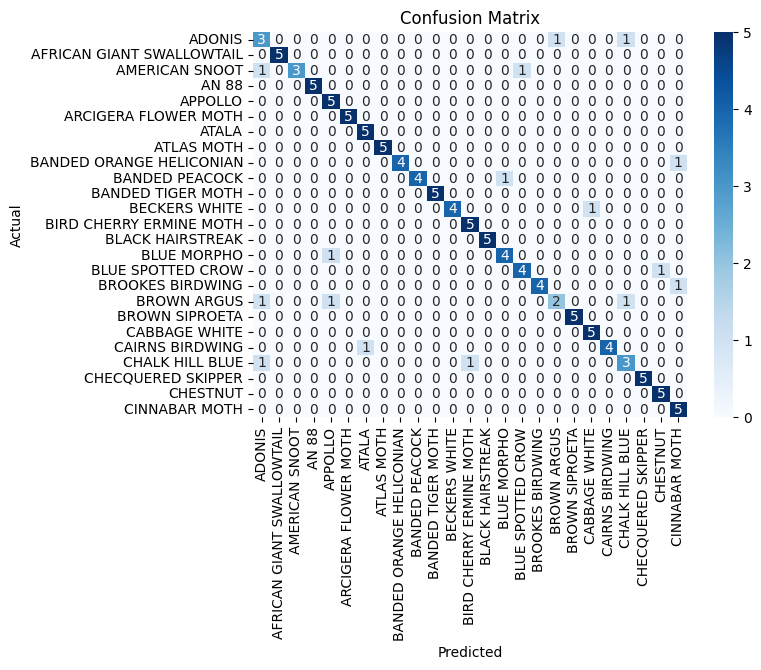

Fully supervised results: Accuracy 0.872, Precision 0.8851, Recall 0.872, F1-score 0.8697171717171718


In [36]:
# Redo the new SVM but using the best kernel and gamma
psuedo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(features_train, labels_train)
predictions = psuedo_classifier.predict(features_test)

cm = confusion_matrix(labels_test, predictions)                # Calculate the confusion matrix

plt.figure(figsize=(7,5))                                        # Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Determine the new estimation parameter 
accuracy = round(accuracy_score(labels_test, predictions), 4)
precision = round(precision_score(labels_test, predictions, average='macro'), 4)
recall = round(recall_score(labels_test, predictions, average='macro'), 4)
f1 = f1_score(labels_test, predictions, average='macro')
print(f'Fully supervised results: Accuracy {accuracy}, Precision {precision}, Recall {recall}, F1-score {f1}')

final_results.append({'Pipeline': 'VGG-SVM', 'Kernel' : best_kernel, 'Gamma' : best_gamma, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})

#### KNN

In [37]:
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(features_train.shape[0]))]       # Use the odd values and the root of the shape
weights = ['uniform', 'distance']                                              # The wights and metrics used
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']

results = []                                                                   # The results array

for n, w, m in product(n_neighbors, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)             # Create the K-NN classifier with the current hyperparameters

    knn.fit(features_train, labels_train)                                    # Fit the model to the training data

    predictions = knn.predict(features_test)                                     # Make predictions on the test data


    # Calulate accuracy, precision, recall and f1 values
    accuracy = round(accuracy_score(labels_test, predictions), 4)
    precision = round(precision_score(labels_test, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(labels_test, predictions, average='macro', zero_division=1), 4)
    f1 = f1_score(labels_test, predictions, average='macro', zero_division=1)

    results.append({'n_neighbors' : n, 'weights' : w, 'metric' : m, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})
    

knn_df = pd.DataFrame(results)                                                 # Create a dataframe with results
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)

print(knn_df)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
47           11  distance     cosine     0.776     0.8039   0.776  0.770398
7             3  distance     cosine     0.776     0.8219   0.776  0.779718
17            5  distance     cosine     0.776     0.8259   0.776  0.777088
37            9  distance     cosine     0.760     0.8197   0.760  0.758884
32            9   uniform     cosine     0.752     0.8167   0.752  0.750824
2             3   uniform     cosine     0.752     0.8258   0.752  0.759576
27            7  distance     cosine     0.752     0.8017   0.752  0.750606
12            5   uniform     cosine     0.752     0.8339   0.752  0.755457
22            7   uniform     cosine     0.744     0.8000   0.744  0.746958
42           11   uniform     cosine     0.736     0.7933   0.736  0.737869
52           57   uniform     cosine     0.720     0.7691   0.720  0.712382
57           57  distance     cosine     0.720     0.7639   0.720  0.710628
9           

#### Confusion Matrix

Accuracy: 0.136


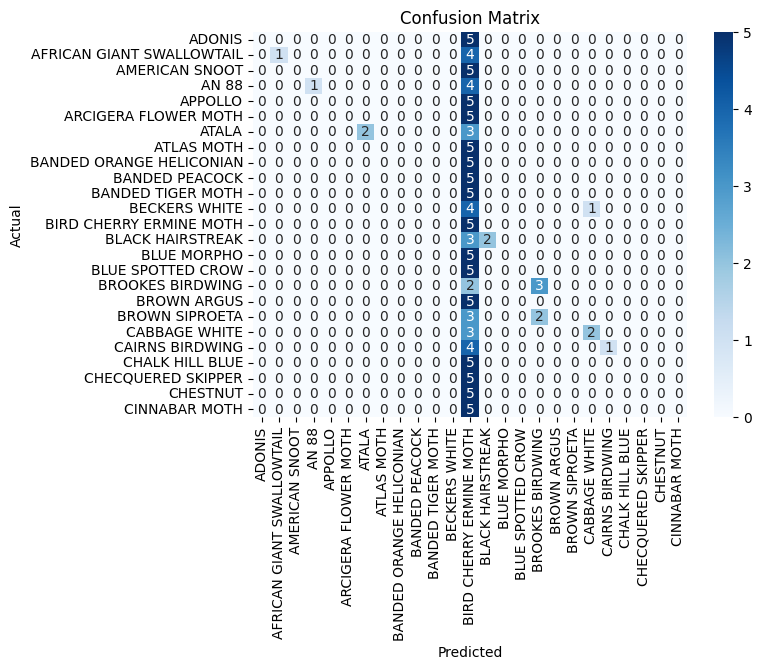

In [38]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric) # With the best parameters create a new model
knn.fit(features_train, labels_train)
y_pred = knn.predict(features_test)

accuracy = accuracy_score(labels_test, y_pred)                                                  # Calculate the accuracy
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(labels_test, y_pred)                                                      # Determinate the confusion matrix

plt.figure(figsize=(7,5))                                                                          # Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_species, yticklabels=list_species)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Store the performance results of the KNN model 
final_results.append({'Pipeline': 'VGG-KNN', 'n_neighbors' : best_n_neighbors, 'weights' : best_weights, 'metric' : best_metric, 'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-score' : f1})


#### Comparing results

In [39]:
res_df = pd.DataFrame(final_results)                                                          # Create DataFrame from final results
res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)     # Sort by last character in Pipeline column descending
res_df                                                                                        # Show the sorted DataFrame

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,0.360,0.6572,0.256,0.226042,3.0,distance,manhattan
3,BW-PCA-KNN,NaN,NaN,0.408,0.6333,0.280,0.249847,3.0,distance,cosine
5,RGB-KNN,NaN,NaN,0.488,0.6366,0.312,0.275086,5.0,distance,manhattan
7,RGB-PCA-KNN,NaN,NaN,0.504,0.7027,0.320,0.282514,3.0,distance,cosine
9,HSV-KNN,NaN,NaN,0.424,0.4731,0.320,0.313528,11.0,uniform,manhattan
11,HSV-PCA-KNN,NaN,NaN,0.280,0.3036,0.168,0.135688,57.0,distance,manhattan
13,VGG-KNN,NaN,NaN,0.136,0.8679,0.336,0.350349,57.0,distance,manhattan
0,BW-SVM,rbf,scale,0.536,0.4905,0.536,0.496092,NaN,NaN,NaN
2,BW-PCA-SVM,rbf,scale,0.512,0.4835,0.512,0.480486,NaN,NaN,NaN
4,RGB-SVM,rbf,scale,0.680,0.7166,0.680,0.670687,NaN,NaN,NaN
